課題：セルにおけるコードの説明（特にStep 6, 7, 8）

## Step 1: Import the Dataset
リンク: https://blog.paperspace.com/seq-to-seq-attention-mechanism-keras/


In [ ]:
!wget http://www.manythings.org/anki/fra-eng.zip

--2021-12-20 01:51:51--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.21.92.44, 172.67.186.54, 2606:4700:3030::6815:5c2c, ...
Connecting to www.manythings.org (www.manythings.org)|104.21.92.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6515217 (6.2M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   6.21M  --.-KB/s    in 0.08s   

2021-12-20 01:51:51 (77.1 MB/s) - ‘fra-eng.zip’ saved [6515217/6515217]



In [ ]:
!unzip /content/fra-eng.zip

Archive:  /content/fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 


In [ ]:
# Get the txt file which has English -> French translation
path_to_file = "fra.txt"

## Step 2: Preprocess the Dataset

### ・ASCIIとは？
ASCIIとは、アルファベットや数字、記号などを収録した文字コードの一つ。最も基本的な文字コードとして世界的に普及しており、他の多くの文字コードがASCIIの拡張になるよう実装されている。文字を7ビットの値（0～127）で表し、128文字が収録されている。
###・UNICODEとは？
Unicodeは全世界共通で使えるように、世界中の文字を収録する文字コード規格である。

###・non-spacking markとは？

■　前進を伴う結合記号 (Spacing combining mark, Mc) 
- デーヴァナーガリー文字の母音 ā i ī などの記号。基底文字の左に置かれることもある。

■　前進を伴わない記号 (Nonspacing mark, Mn) - ダイアクリティカルマークなど

■　囲み記号 (Enclosing mark, Me) - 結合用の円・四角など

#データを準備するための処理を実行する
1. それぞれの文ごとに、開始と終了の文字を付加する

2. 特殊文字を除去して文をきれいにする

3. 単語インデックスと逆単語インデックス（単語 → id　と　id → 単語のマッピングを行うディクショナリ）を作成する
4. 最大長にあわせて各文をパディングする

In [ ]:
# 学習データ等をインポート
import unicodedata
import re

# Convert the unicode sequence to ascii ：ユニコードの配列をascii（アスキー）に変換する
def unicode_to_ascii(s):

  # Normalize the unicode string and remove the non-spacking mark ：ユニコードの文字列を正規化して、ノンスパッキングマークを消す
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

# Preprocess the sequence : 配列の前処理をする
def preprocess_sentence(w):

  # Clean the sequence : 小文字に変換したものをasciiに変換する
  w = unicode_to_ascii(w.lower().strip())

  # Create a space between word and the punctuation following it : 単語とその後に続く句読点の間にスペースを入れる
  # 例：　"he is a boy." => "he is a boy ."
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # Replace everything with space except (a-z, A-Z, ".", "?", "!", ",") : (a-z, A-Z, ".", "?", "!", ",") 以外をスペースで置換する
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # Add a start and stop token to detect the start and end of the sequence : 配列の入力開始と終了を検出するための文字を追加する
  # モデルが予測をいつ開始し、いつ終了すれば良いかを知らせるため
  w = '<start> ' + w + ' <end>'
  return w

In [ ]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"Je peux emprunter ce livre ?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> je peux emprunter ce livre ? <end>'


## Step 3: Prepare the Dataset

In [ ]:
import io

# Create the Dataset : /content/fra.txtを開く
# 1. アクセント記号を除去
# 2. 文をクリーニング
# 3. [ENGLISH, SPANISH] の形で単語のペアを返す
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  # Loop through lines (sequences) and extract the English and French sequences. Store them as a word-pair : 配列を繰り返して、英語とフランス語の配列だけを抽出し、単語のペアとして格納する
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t', 2)[:-1]]  for l in lines[:num_examples]]
  return zip(*word_pairs)

In [ ]:
# 英語とフランス語のデータ表示する
en, fra = create_dataset(path_to_file, None)
print(en[-1])
print(fra[-1])

<start> it may be impossible to get a completely error free corpus due to the nature of this kind of collaborative effort . however , if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning , we might be able to minimize errors . <end>
<start> il est peut etre impossible d obtenir un corpus completement denue de fautes , etant donnee la nature de ce type d entreprise collaborative . cependant , si nous encourageons les membres a produire des phrases dans leurs propres langues plutot que d experimenter dans les langues qu ils apprennent , nous pourrions etre en mesure de reduire les erreurs . <end>


In [ ]:
import tensorflow as tf

# Convert sequences to tokenizers : 配列を単語ごとに区切る(トークナイズする)
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  
  # Convert sequences into internal vocab : 配列を内部語彙に変換する
  lang_tokenizer.fit_on_texts(lang)

  # Convert internal vocab to numbers : 内部語彙を数値に変換する
  tensor = lang_tokenizer.texts_to_sequences(lang)

  # Pad the tensors to assign equal length to all the sequences : すべての配列に等しい長さを割り当てるためにテンソルを詰める
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [ ]:
# Load the dataset : データセットを読み込む
def load_dataset(path, num_examples=None):
  # クリーニングされた入力と出力のペアを生成
  # Create dataset (targ_lan = English, inp_lang = French) : データセットを作る
  targ_lang, inp_lang = create_dataset(path, num_examples)

  # Tokenize the sequences : 配列を単語区切りにする
  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
# Consider 50k examples : ５００００のデータを考える
num_examples = 50000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors : 対象の多次元配列の最大長を計算する
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [ ]:
max_length_targ

11

In [ ]:
max_length_inp

19

## Step 4: Create the Dataset

In [ ]:
from sklearn.model_selection import train_test_split

# Create training and validation sets using an 80/20 split : トレーニングデータをバリデーションデータに分ける、50000×0.2=10000がバリデーション
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

40000 40000 10000 10000


In [ ]:
# Show the mapping b/w word index and language tokenizer : 単語のインデックスと区切った言語の対応関係を表示する　時系列データになっている
def convert(lang, tensor):
  for t in tensor:
    if t != 0:
      print ("%d ----> %s" % (t, lang.index_word[t]))
      
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
8 ----> vous
31 ----> etes
1750 ----> implique
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
5 ----> you
13 ----> re
658 ----> involved
3 ----> .
2 ----> <end>


## Step 5: Initialize the Model Parameters

In [ ]:
# Essential model parameters : 必須のモデルパラメータ、ハイパーパラメータの設定
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index) + 1
vocab_tar_size = len(targ_lang.word_index) + 1

In [ ]:
# 配列と対応するラベルの配列を対応づける、シャッフルして格納
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
# Size of input and target batches : 入力バッチとターゲットバッチのサイズ
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 19]), TensorShape([64, 11]))

## Step 6: Encoder Class

In [ ]:
# Encoder class : エンコーダーのクラスを作成
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units

    # Embed the vocab to a dense embedding : ボキャブラリーを高密度に埋め込む
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

    # GRU Layer
    # glorot_uniform: Initializer for the recurrent_kernel weights matrix, :重み行列の初期化
    # used for the linear transformation of the recurrent state : リカレント状態の線形変換に使用される

    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  # Encoder network comprises an Embedding layer followed by a GRU layer : エンコーダーはembedding層とGRU層から構成される
  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state=hidden)
    return output, state

  # To initialize the hidden state : 隠れ状態を初期化するために
  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

print ('Encoder output shape(batch size, sequence length, units): {}'.format(sample_output.shape))
print ('Encoder Hidden state shape(batch size, units): {}'.format(sample_hidden.shape))

Encoder output shape(batch size, sequence length, units): (64, 19, 1024)
Encoder Hidden state shape(batch size, units): (64, 1024)


## Step 7: Attention Mechanism Class

In [ ]:
# Attention Mechanism : Attention層クラスを作る
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size) : 隠れ状態の形状を問い合わせ
    # values shape == (batch_size, max_len, hidden size) : 値の形状

    # we are doing this to broadcast addition along the time axis to calculate the score : 時間軸に沿った加算を放送し、スコアを計算するために行っています。
    # query_with_time_axis shape == (batch_size, 1, hidden size) : 時間軸の形状を問い合わせ
    # スコアを計算するためにこのように加算を実行する
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1) : スコアの形状
    # we get 1 at the last axis because we are applying score to self.V : スコアを self.V に適用するために最後の軸は 1 となる
    # the shape of the tensor before applying self.V is (batch_size, max_length, units) : self.Vを適用する前のテンソルの形状は (batch_size, max_length, units)である。
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1) : Attentionの重みの形状
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size) : コンテキストベクタの形状を合計したもの
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape(batch size, units): {}".format(attention_result.shape))
print("Attention weights shape(batch_size, sequence_length, 1): {}".format(attention_weights.shape))

Attention result shape(batch size, units): (64, 1024)
Attention weights shape(batch_size, sequence_length, 1): (64, 19, 1)


## Step 8: Decoder Class

In [ ]:
# Decoder class : デコーダーのクラスを作る
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # Used for attention : Attentionをつかう
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # x shape == (batch_size, 1)
    # hidden shape == (batch_size, max_length)
    # enc_output shape == (batch_size, max_length, hidden_size)

    # context_vector shape == (batch_size, hidden_size)
    # attention_weights shape == (batch_size, max_length, 1)
    
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    # 埋め込み層を通過したあとの x の shape  == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size) : 結合後の x の shape
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU : 結合したベクトルを GRU 層に渡す
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 5939)


## Step 9: Optimizer and Loss Functions

入力配列はゼロパディングされてるので、正解がゼロの場合は損失を無効化

In [ ]:
# Initialize optimizer and loss functions
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# Loss function : 誤差関数
def loss_function(real, pred):

  # Take care of the padding. Not all sequences are of equal length.
  # If there's a '0' in the sequence, the loss is being nullified
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Step 10: Train the Model

In [ ]:
import os

checkpoint_dir = '/content/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

# 訓練
1. 入力 を エンコーダー に通すと、エンコーダー出力 と エンコーダーの隠れ状態 が返される

2. エンコーダーの出力とエンコーダーの隠れ状態、そしてデコーダーの入力（これが 開始トークン）がデコーダーに渡される

3. デコーダーは 予測値 と デコーダーの隠れ状態 を返す

4. つぎにデコーダーの隠れ状態がモデルに戻され、予測値が損失関数の計算に使用される

5. デコーダーへの次の入力を決定するために Teacher Forcing が使用される

6. Teacher Forcing は、正解単語 をデコーダーの 次の入力 として使用するテクニックである

7. 最後に勾配を計算し、それをオプティマイザに与えて誤差逆伝播を行う

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  # tf.GradientTape() -- record operations for automatic differentiation
  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    # dec_hidden is used by attention, hence is the same enc_hidden
    dec_hidden = enc_hidden

    # <start> token is the initial decoder input
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input : 正解値を次の入力として供給
    for t in range(1, targ.shape[1]):

      # Pass enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      # Compute the loss
      loss += loss_function(targ[:, t], predictions)

      # Use teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  # As this function is called per batch, compute the batch_loss
  batch_loss = (loss / int(targ.shape[1]))

  # Get the model's variables
  variables = encoder.trainable_variables + decoder.trainable_variables

  # Compute the gradients
  gradients = tape.gradient(loss, variables)

  # Update the variables of the model/network
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
import time

EPOCHS = 30

# Training loop
for epoch in range(EPOCHS):
  start = time.time()

  # Initialize the hidden state
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  # Loop through the dataset
  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):

    # Call the train method
    batch_loss = train_step(inp, targ, enc_hidden)

    # Compute the loss (per batch)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # Save (checkpoint) the model every 2 epochs : 2 エポックごとにモデル（のチェックポイント）を保存
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  # Output the loss observed until that epoch
  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.7393
Epoch 1 Batch 100 Loss 2.2455
Epoch 1 Batch 200 Loss 1.9717
Epoch 1 Batch 300 Loss 1.7551
Epoch 1 Batch 400 Loss 1.4677
Epoch 1 Batch 500 Loss 1.4703
Epoch 1 Batch 600 Loss 1.3213
Epoch 1 Loss 1.7905
Time taken for 1 epoch 137.83443093299866 sec

Epoch 2 Batch 0 Loss 1.2054
Epoch 2 Batch 100 Loss 1.1414
Epoch 2 Batch 200 Loss 1.0842
Epoch 2 Batch 300 Loss 1.0115
Epoch 2 Batch 400 Loss 1.0521
Epoch 2 Batch 500 Loss 0.8026
Epoch 2 Batch 600 Loss 0.7651
Epoch 2 Loss 1.0057
Time taken for 1 epoch 120.22295188903809 sec

Epoch 3 Batch 0 Loss 0.6794
Epoch 3 Batch 100 Loss 0.6060
Epoch 3 Batch 200 Loss 0.5746
Epoch 3 Batch 300 Loss 0.5921
Epoch 3 Batch 400 Loss 0.4732
Epoch 3 Batch 500 Loss 0.6392
Epoch 3 Batch 600 Loss 0.4947
Epoch 3 Loss 0.6091
Time taken for 1 epoch 119.76949787139893 sec

Epoch 4 Batch 0 Loss 0.3510
Epoch 4 Batch 100 Loss 0.3342
Epoch 4 Batch 200 Loss 0.4616
Epoch 4 Batch 300 Loss 0.3579
Epoch 4 Batch 400 Loss 0.3864
Epoch 4 Batch 500 Loss 0.39

# 翻訳
・　評価関数は、Teacher Forcing を使わないことを除いては、訓練ループと同様である。タイムステップごとのデコーダーへの入力は、過去の予測値に加えて、隠れ状態とエンコーダーのアウトプットである。

・　モデルが 終了トークン を予測したら、予測を停止する。

・　また、タイムステップごとのアテンションの重み　を保存する。

## Step 11: Test the Model

In [ ]:
import numpy as np

# Evaluate function -- similar to the training loop
def evaluate(sentence):

  # Attention plot (to be plotted later on) -- initialized with max_lengths of both target and input
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  # Preprocess the sentence given
  sentence = preprocess_sentence(sentence)

  # Fetch the indices concerning the words in the sentence and pad the sequence
  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  # Convert the inputs to tensors
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  # Loop until the max_length is reached for the target lang (ENGLISH)
  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)
    # 後ほどプロットするためにアテンションの重みを保存
    # Store the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    # Get the prediction with the maximum attention
    predicted_id = tf.argmax(predictions[0]).numpy()

    # Append the token to the result
    result += targ_lang.index_word[predicted_id] + ' '

    # If <end> token is reached, return the result, input, and attention plot
    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # The predicted ID is fed back into the model : 予測された ID がモデルに戻される
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

## Step 12: Plot and Predict

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Function for plotting the attention weights : アテンションの重みをプロットする関数
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
# Translate function (which internally calls the evaluate function)
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
# Restore the latest checkpoint in checkpoint_dir : checkpoint_dir の中の最後のチェックポイントを復元
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> as tu lu ce livre ? <end>
Predicted translation: did you read that book ? <end> 


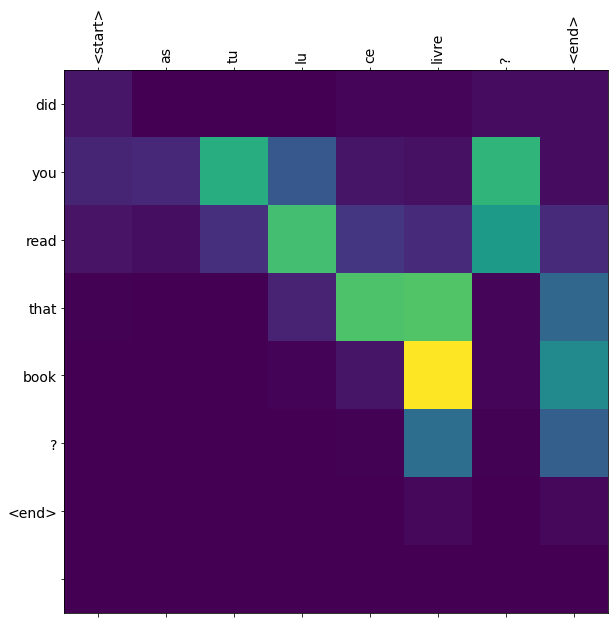

In [ ]:
translate(u"As tu lu ce livre?") # Have you read this book?

Input: <start> comment as tu ete ? <end>
Predicted translation: how did you have ? <end> 


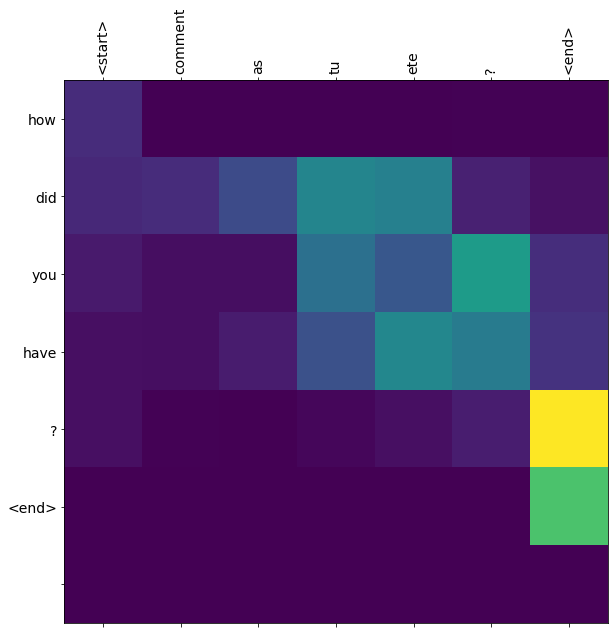

In [ ]:
translate(u"Comment as-tu été?") # How have you been?